In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In /home/amin/.local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/amin/.local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/amin/.local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/amin/.local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/amin/.local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_c

In [3]:

f = h5py.File('Dataset/train_catvnoncat.h5', 'r')

classes = f['list_classes'][()]
train_set_x = f['train_set_x'][()] / 255  # normalizing
train_set_y = f['train_set_y'][()]

f.close()

f = h5py.File('Dataset/test_catvnoncat.h5', 'r')

test_set_x = f['test_set_x'][()] / 255    # normalizing
test_set_y = f['test_set_y'][()]

f.close()

In [4]:
def print_metrics(y, predict_y):
    test_accuracy = 1 - (np.abs(y - predict_y).sum() / np.abs(y - predict_y).size)

    cat1 = set(np.where(y == 1)[0])
    cat1_predict = set(np.where(predict_y == 1)[0])

    test_recall_cat1 = 1 - (len(cat1.difference(cat1_predict)) / len(cat1))
    test_precision_cat1 = 1 - (len(cat1_predict.difference(cat1)) / len(cat1_predict)) if len(cat1_predict) else 0

    cat0 = set(np.where(y == 0)[0])
    cat0_predict = set(np.where(predict_y == 0)[0])

    test_recall_cat0 = 1 - (len(cat0.difference(cat0_predict)) / len(cat0))
    test_precision_cat0 = 1 - (len(cat0_predict.difference(cat0)) / len(cat0_predict)) if len(cat0_predict) else 0

    print(f'accuracy: {test_accuracy*100}%')
    print(f'cat0 --> recall: {test_recall_cat0 * 100}%  precision: {test_precision_cat0 * 100}%')
    print(f'cat1 --> recall: {test_recall_cat1 * 100}%  precision: {test_precision_cat1 * 100}%')

## رگرسیون لاجستیک

In [5]:
class LogisticRegression:

    def __init__(self):
        self.param = None
        self.last_grad = None
        self.last_cost = None

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def internal_mult(self, x):
        return np.dot(x, self.param)

    def probability(self, x):
        return self.sigmoid(self.internal_mult(x))

    def predict(self, x):
        reshaped_x = self.reshape_x(x)
        return np.int0(np.greater(self.probability(reshaped_x), 0.5))

    def cost_function(self, x, y):
        # total_cost = -1 * (y * np.log(self.probability(x)) + (1 - y) * np.log(1 - self.probability(x)))
        total_cost = (y - self.probability(x))**2
        return total_cost

    def gradient(self, x, y):
        return x * (y - self.probability(x))

    def initial_param(self, x):
        input_num = int(x.size / x.shape[0])
        self.param = np.random.rand(input_num) * 2 - 1
        
    def fit_sample(self, sample, learning_rate):
        x = sample[:-1]
        y = sample[-1]
        self.compute_gradient(x, y)
        self.param += learning_rate * self.last_grad
        return self.last_cost
    
    def fit_in_iter(self, iter_num, x, y, learning_rate):
        reshaped_x = self.reshape_x(x)
        indexes = np.arange(reshaped_x.shape[0])
        np.random.shuffle(indexes)
        samples = np.zeros((reshaped_x.shape[0], reshaped_x.shape[1] + 1))
        samples[:, :-1] = reshaped_x[indexes]
        samples[:, -1] = y[indexes]
        costs = np.apply_along_axis(self.fit_sample, 1, samples, learning_rate)
        print(f'iter {iter_num}  loss {np.sum(costs)}')
                
    def fit(self, x, y, learning_rate=0.1, iter_num=10):
        np.random.seed(1)
        self.initial_param(x)
        vf = np.vectorize(self.fit_in_iter, excluded=['x', 'y'])
        vf(iter_num=np.arange(iter_num - 1), x=x, y=y, learning_rate=learning_rate)

    def compute_gradient(self, x, y):
        self.last_cost = self.cost_function(x, y)
        self.last_grad = self.gradient(x, y)

    @staticmethod
    def reshape_x(x):
        first_dim = x.shape[0]
        other_dim = int(x.size / first_dim)
        return np.reshape(x, (first_dim, other_dim))

پارامتر هامون رو داخل اتربیوت پارام نگه میداریم که در هنگام پردیکت کردن میایم این وزن ها رو ضرب داخلی میکنیم در ورودی و در انتها از خروجی سیگمویت میگیریم و میشه خروجی مون که یه عدد بین صفر و یکه بزرگتر از نیم یعنی کت ۱ و کوچیکتر یعنی کت ۰

در ترین هم در طول چند ایتریشن همه ی داده های مون رو یکی یکی ترین میکنیم، اینجوری که گرادیانت رو حساب میکنیم توسط تابعی که گذاشتیم و هر بار پارامتر هامون رو به علاوه ی گراد میکنیم تا اینجوری لاس رو بتونیم کم و کمتر کنیم

In [103]:
lr = LogisticRegression()
lr.fit(train_set_x, train_set_y, iter_num=20, learning_rate=0.05)

iter 0  loss 92.17587247495595
iter 0  loss 80.37412506135985
iter 1  loss 69.54867686863483
iter 2  loss 67.27969068495716
iter 3  loss 63.30898273713774
iter 4  loss 54.96653803404797
iter 5  loss 66.20807143989
iter 6  loss 54.42723119502702
iter 7  loss 47.04626913947441
iter 8  loss 49.60677917724202
iter 9  loss 50.464158203038025
iter 10  loss 41.61169595699018
iter 11  loss 46.942061671956324
iter 12  loss 50.65393268751094
iter 13  loss 37.49774669839674
iter 14  loss 21.68720694456993
iter 15  loss 29.807267568326367
iter 16  loss 34.43690479132993
iter 17  loss 32.936340648587255
iter 18  loss 26.26248710484952


لاس فانکشنی که ما اینجا استفاده کردیم توان دو تفاوت بین کتگوری واقعی و خروجی مدله

در هر ایتریشن کل داده های سمپل به صورت رندوم شافل میشه و گرادیانت اش حساب و وزن ها آپدیت میشن

همون طور که مشاهده میشه در طول ایتریشن ها لاس مون داره پایین میاد در ابتدا ۹۲ بوده ولی در انتهای کار ترین به ۲۶ رسیده که به این معنیه مدلمون به خوبی گرادیانت رو حساب کرده و وزن رو ها رو داره به خوبی آپدیت میکنه

در طول ایتریشن های مختلف گاهی لاس بالا و پایین میشه اما روند کلیش نزولیه، دلیل این اتفاق در اینجا شافل کردن سمپل هاست 



In [104]:
print_metrics(train_set_y, lr.predict(train_set_x))
print_metrics(test_set_y, lr.predict(test_set_x))

accuracy: 95.69377990430623%
cat0 --> recall: 94.16058394160584%  precision: 99.23076923076923%
cat1 --> recall: 98.61111111111111%  precision: 89.87341772151899%
accuracy: 74.0%
cat0 --> recall: 64.70588235294117%  precision: 61.111111111111114%
cat1 --> recall: 78.78787878787878%  precision: 81.25%


اکورسی به معنای تعداد تخمین های درست مدل به تعداد کل تخمین هاست و یک معیار کلی برای مدلمونه

ریکال برای هر کتگوری تعریف میشه و به این معناست که چند درصد از داده هایی که واقعا اون کتگوری بودن رو ما درست تشخیص دادیم

پرسیژن هم به ازای هر کتگوری تعریف میشه و بیان میکنه چند درصد از سمپل هایی که ما اون کتگوری رو براشون پردیکت کردیم واقعا همون کتگوری بودن

مقادیر اکورسی کلی مدل، ریکال و پرسیژن برای هر کدوم از کتگوری ها برای داده های تست و ترین به صورت جدا در بالا نشون داده شده 

## شبکه عصبی

In [6]:
class NeuralNetwork:
    def __init__(self, in_num, layer1, layer2, layer3, layer4):
        np.random.seed(2)
        self.layer1 = {'param': self.initial_layer_param(in_num, layer1),
                       'output': None,
                       'error': None}
        self.layer2 = {'param': self.initial_layer_param(layer1, layer2),
                       'output': None,
                       'error': None}
        self.layer3 = {'param': self.initial_layer_param(layer2, layer3),
                       'output': None,
                       'error': None}
        self.layer4 = {'param': self.initial_layer_param(layer3, layer4),
                       'output': None,
                       'error': None}
        self.layer5 = {'param': self.initial_layer_param(layer4, 2),
                       'output': None,
                       'error': None}
        self.input = None
        self.expected = None

    @staticmethod
    def initial_layer_param(in_num, out_num):
        return np.random.rand(out_num, in_num + 1) * 2 - 1  # better without normalization

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def internal_mult(x, param):
        result = np.dot(param[:, :-1], x) + param[:, -1]    # better without bias
        return result

    @staticmethod
    def output_layer(x, param):
        result = NeuralNetwork.sigmoid(NeuralNetwork.internal_mult(x, param))
        return result

    def forward_propagate(self):
        self.layer1['output'] = self.output_layer(self.input, self.layer1['param'])
        self.layer2['output'] = self.output_layer(self.layer1['output'], self.layer2['param'])
        self.layer3['output'] = self.output_layer(self.layer2['output'], self.layer3['param'])
        self.layer4['output'] = self.output_layer(self.layer3['output'], self.layer4['param'])
        self.layer5['output'] = self.output_layer(self.layer4['output'], self.layer5['param'])
        return self.layer5['output']

    @staticmethod
    def transfer_derivative(layer_output):
        transfer_derivative = layer_output * (1-layer_output)
        return transfer_derivative

    def backward_propagate(self):
        self.layer5['error'] = (self.expected - self.layer5['output']) * self.transfer_derivative(self.layer5['output'])
        self.layer4['error'] = np.dot(self.layer5['error'], self.layer5['param'][:, :-1]) * self.transfer_derivative(
            self.layer4['output'])
        self.layer3['error'] = np.dot(self.layer4['error'], self.layer4['param'][:, :-1]) * self.transfer_derivative(
            self.layer3['output'])
        self.layer2['error'] = np.dot(self.layer3['error'], self.layer3['param'][:, :-1]) * self.transfer_derivative(
            self.layer2['output'])
        self.layer1['error'] = np.dot(self.layer2['error'], self.layer2['param'][:, :-1]) * self.transfer_derivative(
            self.layer1['output'])

    def update_param(self, learning_rate):
        def mult_array(neuron_error, inputs):
            return neuron_error * inputs
        vf = np.vectorize(mult_array, excluded=['inputs'], otypes=[np.ndarray])

        layer1_delta = np.vstack(vf(neuron_error=self.layer1['error'], inputs=self.input)) * learning_rate
        self.layer1['param'][:, :-1] += layer1_delta
        self.layer1['param'][:, -1] += learning_rate * self.layer1['error']   # updating bias

        layer2_delta = np.vstack(vf(neuron_error=self.layer2['error'], inputs=self.layer1['output'])) * learning_rate
        self.layer2['param'][:, :-1] += layer2_delta
        self.layer2['param'][:, -1] += learning_rate * self.layer2['error']  # updating bias

        layer3_delta = np.vstack(vf(neuron_error=self.layer3['error'], inputs=self.layer2['output'])) * learning_rate
        self.layer3['param'][:, :-1] += layer3_delta
        self.layer3['param'][:, -1] += learning_rate * self.layer3['error']  # updating bias

        layer4_delta = np.vstack(vf(neuron_error=self.layer4['error'], inputs=self.layer3['output'])) * learning_rate
        self.layer4['param'][:, :-1] += layer4_delta
        self.layer4['param'][:, -1] += learning_rate * self.layer4['error']  # updating bias

        layer5_delta = np.vstack(vf(neuron_error=self.layer5['error'], inputs=self.layer4['output'])) * learning_rate
        self.layer5['param'][:, :-1] += layer5_delta
        self.layer5['param'][:, -1] += learning_rate * self.layer5['error']  # updating bias

    @staticmethod
    def loss_function(output, expected):
        return np.sum((expected - output) ** 2)

    def train_sample(self, sample, learning_rate):
        self.input = sample[:-1]
        y = sample[-1]
        self.expected = np.zeros(2)
        self.expected[1] = y == 1
        self.expected[0] = y == 0
        output = self.forward_propagate()
        y_predict = int(output[1] > output[0])
        self.backward_propagate()
        self.update_param(learning_rate)
        loss = self.loss_function(output, self.expected)
        return loss, y_predict

    def train_in_epoch(self, epoch_num, x, y, learning_rate):
        reshaped_x = self.reshape_x(x)

        indexes = np.arange(reshaped_x.shape[0])
        np.random.shuffle(indexes)    # without shuffle last item are in order and the last zeros really effect finall output, like the last output would always be zeros

        samples = np.zeros((reshaped_x.shape[0], reshaped_x.shape[1] + 1))
        samples[:, :-1] = reshaped_x[indexes]
        samples[:, -1] = y[indexes]

        output = np.apply_along_axis(self.train_sample, 1, samples, learning_rate)
        loss = np.sum(output[:, 0])
        predicts = np.int32(output[:, 1])
        # print(np.reshape(np.vstack(predicts), len(predicts)))
        # print(f'epoch {epoch_num}, cost {loss}')
        return loss

    def train(self, x, y, learning_rate, n_epoch):
        vf = np.vectorize(self.train_in_epoch, excluded=['x', 'y'])
        losses = vf(epoch_num=np.arange(n_epoch - 1), x=x, y=y, learning_rate=learning_rate)
        fig, ax = plt.subplots(figsize=(10,6))
        plt.bar(np.arange(len(losses)), losses)
        plt.xticks(np.arange(len(losses)), np.arange(len(losses)))
        ax.set_title('Feagure 1: cost over iter')
        plt.show()


    def predict_sample(self, sample):
        self.input = sample
        output = self.forward_propagate()
        predicts = int(output[1] > output[0])
        return predicts

    def predict(self, x):
        reshaped_x = self.reshape_x(x)
        result = np.apply_along_axis(self.predict_sample, 1, reshaped_x)
        return result

    @staticmethod
    def reshape_x(x):
        first_dim = x.shape[0]
        other_dim = int(x.size / first_dim)
        return np.reshape(x, (first_dim, other_dim))

خیلی مشابه به لاجستیک رگرشن عمل میکنیم و همونجوری پارام داریم و گرادیانت رو حساب میکنیم و با پارامتر هامون جمع میکنیم

در عملیات ترینمون اول فوروارد میکنیم یعنی از لایه اول شروع میکنیم خروجی های هر لایه رو جنریت میکنیم و میریم لایه بعد، بعدش بکوارد پروپگیت که گرادیانت هر لایه به کمک گرادیانت لایه بعدش حساب میشه و همینجور اررور پروپگیت میشه تا لایه اول

و در نهایت پارامتر های هر لایه رو به علاوه ی مقدار دلتایی میکنیم که به دست آوردیم

فرآیند ترین هم عملا همون فوروارده فقط در لایه آخر که دوتا نود داره بر اساس اینکه کدوم ماکسیمم مقدار رو برگردونده کتگوری رو انتخاب میکنه

epoch 0, cost 98.47269732743926
epoch 0, cost 91.06286393067563
epoch 1, cost 82.91750291375516
epoch 2, cost 69.61092921084838
epoch 3, cost 51.616726289591654
epoch 4, cost 34.10936757122494
epoch 5, cost 25.49828309037448
epoch 6, cost 18.470442877025746
epoch 7, cost 9.462471825147166
epoch 8, cost 4.801807740413623


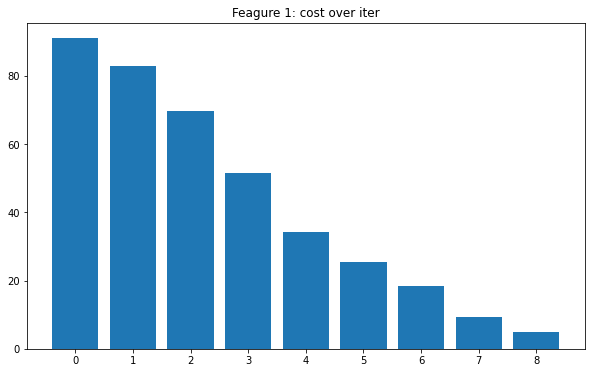

In [13]:
nn = NeuralNetwork(3*64*64, 64*32, 32*8, 16*4, 8)
nn.train(train_set_x, train_set_y, 0.1, 10)

ما در اینجا بچ سایز رو ۱ گرفتیم و ترین روی هر یه دونه داده صورت میگیره، وقتی بچ سایز خیلی کوچیک باشه مثل اینجا باید لرنینگ ریت رو بیاریم پاییم چون نمیخوایم داده های آخر همیشه تاثیر زیادی روی مدل داشته باشن و اون رو بایاس کنن داده هارو هم باید شافل کنیم که باز هم داده های آخرمون توی هر اپوک مشخص نباشن و مدلمون بهتر ترین بشه

همونطور که از نمودار لاس معلومه در طول ایتریشن های مختلف مقدار لاس همواره در حال پایین اومدنه، بنابراین با افزایش تعداد اپوک ها حتی میتونیم لاس رو از اینی که هست هم پایین تر بیاریم البته اینکار فرآیند رو زمان بر میکنه و همچنین باعث اورفیت میشه

گاهی اوقات لاس بین ایتریشن ها بالا و پایین میشه اما روند کلیش نزولیه البته در این حالت خاص رخ نداده ولی اگه اپوک ها رو بیشتر کنیم این بالا و پایین رفتن ها رو میتونیم ببینیم، دلیل این بالا و پایین رفتن ها به خاطر کوچیک بودن بچ سایز و همچنین شافل کردنشونه، بعضی وقت ها این شافل باعث میشه که ترین هر سمپل جوری باشه که لاس برای سمپل بعد ماکسیمم بشه، ولی خوب روند کلی رو وقتی در نظر بگیریم لاس روندش نزولیه

گاها لاس هامون روی یک مقدار خاص مینیمم میشن و با زیاد کردن تعداد اپوک نمیتونیم لاس رو از او ن مقدار کاهش بدیم که البته در این حالت با این تعداد لاس محدود قابل مشاهده نیست این اتفاق


In [14]:
print_metrics(train_set_y, nn.predict(train_set_x))
print_metrics(test_set_y, nn.predict(test_set_x))

accuracy: 100.0%
cat0 --> recall: 100.0%  precision: 100.0%
cat1 --> recall: 100.0%  precision: 100.0%
accuracy: 52.0%
cat0 --> recall: 82.35294117647058%  precision: 40.0%
cat1 --> recall: 36.36363636363637%  precision: 80.0%


در گرید سرچ ما یه سری مقدار برای هایپر پارامتر های مختلفمون انتخاب میکنیم مثلا برای لرنینگ ریت مقادیر 0.1, 0.07, 0.05, 0.02 انتخاب میشه و برای تعداد ایتریشن ها مقادیر 3, 5, 7 و 10 انتخاب میشه

گرید سرچ بر اساس این مقادیری که ایجاد شده تمام ترکیب های مختلف اونها رو میسازه و امتحان میکنه و بهترین ترکیب رو برمیگردونه مثلا در این جا ۱۶ حالت ترکیب مختلف وجود داره که گرید سرچ تمام اون حالت ها رو امتحان میکنه و بر اساس تابعی که بهش دادیم که در اینجا اکورسی روی داده های تستمون مد نظره بهترین ترکیب رو برمیگردونه، فرآیند خیلی زمان بره ولی خوب نتیجه ی خیلی خوبی میتونه بده

در رندوم سرچ هم دامنه هایپر پارامتر ها رو میتونیم انتخاب میکنیم (گسسته یا پیوسته) و تعداد سرچ رو مشخص میکنیم، این الگوریتم از تمام ترکیب های ممکنه تعدادی که مشخص شده رو به صورت رندوم انتخاب میکنه و بهترین رو برمیگردونه، زمان کمتری نسبت به گرید نیاز داره در عین حال میتونه جواب قابل قبولی هم بده



------------------ lr 0.07 epoch 7.0 ------------------


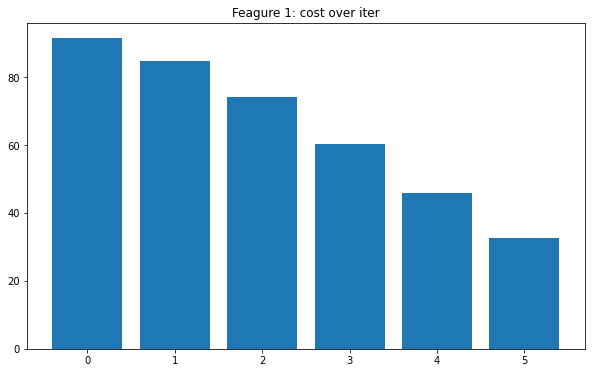

0.54
------------------ lr 0.02 epoch 7.0 ------------------


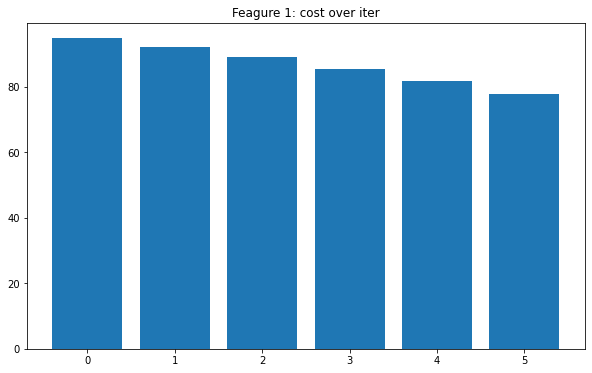

0.34
------------------ lr 0.07 epoch 10.0 ------------------


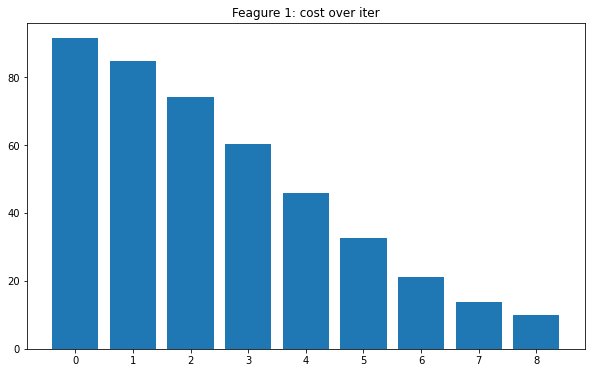

0.56
------------------ lr 0.02 epoch 10.0 ------------------


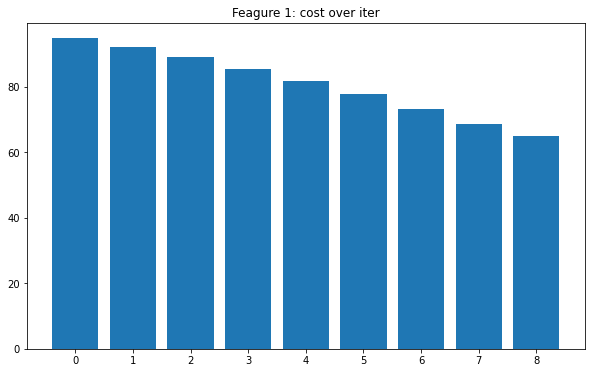

0.34
------------------ lr 0.05 epoch 5.0 ------------------


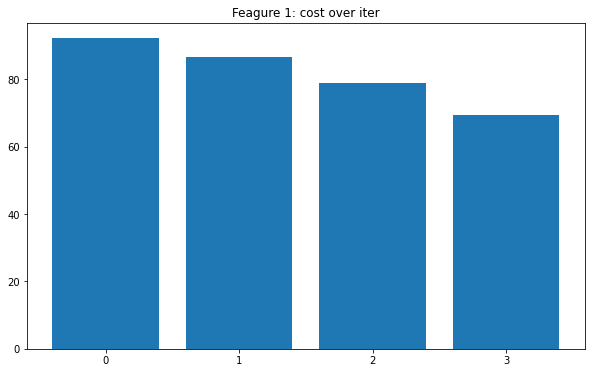

0.34
best choise:
lr=0.07, epoch=10.0


In [6]:
learning_rates = [0.1, 0.07, 0.05, 0.02]
epoch_nums = [10, 7, 5]


parameter_comb = np.stack(np.meshgrid(learning_rates, epoch_nums), -1).reshape(-1, 2)
random_combination = parameter_comb[np.random.choice(np.arange(len(parameter_comb)), 5)]
def cost_function(parameter):
    learning_rate, epoch = parameter
    print(f'------------------ lr {learning_rate} epoch {epoch} ------------------')
    nn = NeuralNetwork(3*64*64, 64*32, 32*8, 16*4, 8)
    nn.train(train_set_x, train_set_y, learning_rate, epoch)
    predict = nn.predict(test_set_x)
    test_accuracy = ((test_set_y - predict)==0).sum() / len(predict)
    print(test_accuracy)
    return test_accuracy

accuracies = np.apply_along_axis(cost_function, 1, random_combination)
best_lr, best_epoch = random_combination[np.where(accuracies==np.max(accuracies))[0][0]]
print('best choise:')
print(f'lr={best_lr}, epoch={best_epoch}')

مقدار دهی رندوم وزن ها در شبکه عصبی

ما توی شبکه عصبی نیاز داریم وزن ها رو رندوم مقدار دهی کنیم چون اگه به جای مقدار رندوم از یک مقدار ثابت استفاده کنیم اون وقت تاثیر هر کدوم از سمپل ها روی مدل زیاد میشه مثلا سمپل اول وزن ها رو کاملا در مسیر خودش تغییر میده، این اتفاق باعث میشه که اکثریت سمپل هامون که از کتگوری صفر هستن روی مدل بیشترین تاثیر بزارن و مدلمون بعد ترین شدن پردیکتش همیشه کت صفر میمونه

یه مشکل دیگه هم که وزن اولیه ثابت داره اینه که همیشه مدلمون به سمت یه مینیموم محلی خاص میره در حالی که وزن اولیه رندوم میتونه ما رو به مینینموم های محلی مختلف برسونه


انواع اکتیویشن فانکشن ها

باینری: از یک ترشولدی به بعد مقدار ۱ میده و قبلش مقدار صفر مشکلاتش یکی فقط امکان کلاسیفیکیشن برای دوتا کتگوری رو داره دوم گرادیانتش همیشه صفره و آپدیت کردن وزن ها رو مشکل میکنه

خطی: این فانکشن هم فانکشن خطی هست که خود مقدار ورودی رو داره خروجی میده، مشتقش ثابته در نتیجه امکان بک پروپگیت نمیده، و اینکه وجود چند لایه عملا ب منطق میشه و همیشه لایه آخر خروجی خطی نسبت به ورودی داره

سیگمویت: غیر خطیه در نتیجه مشکلات تابع خطی رو نداره، اجازه ی جامپ به مقادیر خیلی زیاد رو نمیده، مقدار خروجی اش در بازه ی مشخصی قرار داره و برای مقادیر بزرگتر از ۲ پردیکشن مشخص میشه و نزدیک به ۱ میشه، بدی هاش هم اینکه برای مقادیر خیلی بزرگ یا خیلی کوچیک مشتقش خیلی کم میشه و در نتیجه تغییری در آپدیت وزن ها نمیبینیم، خروجی منفی نمیده و هزینه بره

تانژانت هایپربولیک: نسبت به سیگمویت خروجیش به مرکز صفره و مقادیر منفی هم میده بقیه ویژگی هاش مثل سیگمویته

رلو: برای مقادیر بزرگتر از صفر خطی و کمتر از صفر برابر با صفره، خوبیش نسبت به سیگمویت و تاینژانت هایپربولیک اینه که خیلی سریع میتونه رشد کنه چون گرادیانتش برای مقادیر خیلی بالا کم نیست و اجازه ی تغییر رو میده، به همین خاطر محاسباتش هم خیلی افیشنت تره از مشکلاتش هم اینه که برای مقادیری که به صفر میل میکنن یا منفی هستن مقدار گراد صفر میشه و  عملا نمیشه بک پروپگیت رو انجام داد

لیکی رلو، پارامتریک رلو و گاوس هم بسیار شبیه رلو هستن ولی هر کدومشون سعی میکنن مشکلاتی از رلو رو حل کنن که البته در کنارش ممکنه مشکلات جدید رو هم اضافه کنن

در نهایت خیلی به مدل ورودی های نورن و خروجی که دوست داریم ازش بگیریم ربط داره که از چه اکتیویشن فانکشن استفاده کنیم

## scikit learn

In [28]:
from sklearn.ensemble import RandomForestClassifier

reshaped_x = NeuralNetwork.reshape_x(train_set_x)
reshaped_test = NeuralNetwork.reshape_x(test_set_x)

model = RandomForestClassifier(max_depth=8, n_estimators=50, max_features=0.9, min_samples_split=20)
model.fit(reshaped_x, train_set_y)
predict = model.predict(reshaped_x)
print_metrics(train_set_y, predict)
predict = model.predict(reshaped_test)
print_metrics(test_set_y, predict)

accuracy: 100.0%
cat0 --> recall: 100.0%  precision: 100.0%
cat1 --> recall: 100.0%  precision: 100.0%
accuracy: 70.0%
cat0 --> recall: 88.23529411764706%  precision: 53.57142857142857%
cat1 --> recall: 60.60606060606061%  precision: 90.9090909090909%


In [45]:
from sklearn.metrics import log_loss

log_loss(train_set_y, model.predict_proba(reshaped_x))

0.25769303296139096

دلیل انتخاب

مدل لاجستیک رگرسیون به دلیل خطی بودن نمی تونه به خوبی تسک ایمیج کلاسیفیکیشن رو انجام بده، چرا که معمولا پیکسل ها کنار هم معنا پیدا میکنن و در فضای خطی به خوبی نمیشه این ارتباط رو تاثیر داد

مدل همسایه هم یه مشکلی که داره نسبت به اسکیل عکس و یا روتیت اش حساسه، مثلا اگه عکس یک مربع رو ترین کنیم روتیت شده ی این عکس کلی با عکس اصلی میتونه فاصله داشته باشه در نتیجه اینجا شاید خوب عمل نکنه

بهترین مدل دسیژن تریه که مشکلات دو تا مدل قبل رو نداره، من در اینجا از رندوم فورست استفاده کردم که مجموعه از درخت ها رو ترین میکنه و این کمک میکنه بتونیم الگو های متفاوت توی دیتامون رو ترین کنیم

چندتا از هایپر پارامتر های رندوم فورست 

مکس دپس که مکس دپس درخت هامون رو ست میکنه، کم گذاشتنش میتونه کمک کنه اورفیت ندیم اینجا هم ۸ گذاشتم من

تعداد استیمیتور ها که تعداد درخت هایی که ترین میشن رو نشون میده هر چی بیشتر باشه الگو های بیشتری از دیتامون رو میتونیم در بیاریم و اورفیت رو هم میتونیم کم کنیم اینجا ۵۰ گذاشتیم

مکس فیچرز تعد فیچر هایی که به هر درخت داده میشه، اگه به همه ی درخت هامون تمامی فیچر هامون رو بدیم که درخت هامون یه شکل ترین میشن ولی اگه تعداد کمتری فیچر به هر درخت بدیم هر کدوم از درخت هامون میتونن الگوی بین اون فیچر ها رو پیدا کنن، اورفیت کم میشه و مدل کلیمون هم میتونه الگو های پیچیده تری رو در بیاری این جا من ۹۰ درصد فیچر گذاشتم چون که خیلی وجود پیکسل ها کنار هم مهمه و شاید جدا کردنش به اجزای کوچک تر زیاد خوب نباشه مخصوصا اگه این اجزا بهم متصل نباشن

تعداد سمپل های اسپلیت تعیین میکنه حداقل چند تا سمپل باید وجود داشته باشه تا یه نود بشکنه، کم کردنش باعث اورفیت و البته سنگین شدن عملیات ترین میشه، بیشتر کردنش هم برعکس عمل میکنه اینجا ۲۰ گذاشتیم

مکس سمپلز هم داره که تعیین میکنه چند درصد از سمپل ها به هر درخت برسه که من اینجا ست نکردم

## جمع بندی

|            | لاجستیک | شبکه عصبی  | فارست |
|------------|-------|------------|--------|
|  accurace  |  70   |     52     |   74   |
|  recall 0  |  88   |     82     |   64   |
|  recall 1  |  60   |     36     |   78   |
| precision 0|  53   |     40     |   61   |
| precision 1|  90   |     80     |   81   |
|   loss     | 0.25  |     26     |  4.8   |

ما توی مدل لاجستیک درصد ۷۴ برای این مسئله گرفتیم که خیلی درصد خوبی بود، این اسکور حتی از رندوم فورست هم بهتر بود که خوب فکر میکنم برای اینه که مقدار ۷۴ واقعا بهتری مقداری که میشه گرفت و خیلی خوب تیون شده در حالی که تعداد هایپر پارامتر های رندوم فورست خیلی بیشتر بود و خوب پیدا کردن مقدار تیون شدشون یکم سخته اگه به درصد های ترینمون در رندوم فارست و لاجستیک نگاه کنیم میشه فهمید رندوم فارست کمی اورفیت داره جای بهتر شدن داره


در نورال نتورک زیاد درصد خوبی نگرفتیم، من حس میکنم اگه قابلیت های بیشتر و بهتری به نورال نتورکمون میدادیم مثل بچ بچ کردن داده و ترین کردن روی بچ ها، استفاده از ممنتوم و دکوی وزن استفاده میکردیم خیلی نتیجه بهتری میگرفتیم، همینطور که میبینیم این شبکه مون دچار اورفیت شده و تفاوت درصد بین ترین و تست زیاده که با تیون کردن پارامتر ها احتمالا بشه درصد بهتری در تست گرفت اما به دلیل زمان بر بودن فرآیند ترین این مدل (چون روی سی پی یو بود) زمان کافی برای تیون کردنش نداشتم.
در نهایت به نظرم شبکه عصبیمون هنوز جای کار داشت و میتونیم با کار کردن روش خیلی نتایج بهتری ازش گرفت

در نهایت مدل رندوم فارست که اون هم اسکور خیلی خوبی گرفت با وجود اینکه نسبت به شبکه عصبی زیاد مدلی نیست که توی ایمیج کلاسیفیکیشن استفاده میشه

## منابع
[1.](https://towardsdatascience.com/building-a-logistic-regression-in-python-301d27367c24)

[2.](https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/)

[3.](https://missinglink.ai/guides/neural-network-concepts/7-types-neural-network-activation-functions-right/)